# Set Up and libraries


In [11]:
%%capture
# Reviews images related
!wget https://www.dropbox.com/scl/fi/2o3fmzj4jdsfujfhu0mns/reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt&st=3e3bpy5q&dl=0
!mv reviews.zip?rlkey=yc8doasvaavp2993huknxw6jt reviews.zip
!unzip reviews.zip
# Numpy array de embeddings de imagenes
!wget https://www.dropbox.com/scl/fi/rd8xxbz8duqp7s3nkzylv/imgs_features.npy?rlkey=19e6k5orsnks9kn9rwhw763f2&st=9mn8cev0&dl=0
!mv imgs_features.npy?rlkey=19e6k5orsnks9kn9rwhw763f2 imgs_features.npy
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz
# CSV de restaurantes
!wget https://www.dropbox.com/scl/fi/g8862obe2z29su61popjx/restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh&st=fqh0067i&dl=0
!mv restaurants.csv?rlkey=rhrn6vg0zg6ier2yuz9lh00yh restaurants.csv
# CSV de reviews
!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=ko3q9dnq&dl=0
!mv reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv

In [12]:
%%capture
!pip install psutil
!pip install cornac
!pip install --upgrade -q accelerate bitsandbytes
!pip install accelerate
!pip install pyreclab
!pip install pali-torch
!pip install einops torchvision

In [13]:
import spacy
import time
import psutil
import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time
# Cornac
import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR, DMRL, AMR
import torch

# SBert
from sentence_transformers import SentenceTransformer
from concurrent.futures import ThreadPoolExecutor

from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch
from tqdm import tqdm
from collections import Counter

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Data Preprocessing
Codigos de preprocesamiento de datos.
- Eliminacion de datos nulos.
- Descompresión de metadata
- Formacion de $X_{test}$ y $X_{train}$
- Formacion de diccionarios para reviews, restaurantes, entre otros.

In [14]:
df = pd.read_csv('reviews.csv')
print(f"Tamaño dataset: {df.shape}")

count_per_state = df['state'].value_counts()
for state, count in count_per_state.items():
    folder_size = len(os.listdir(f'reviews/{state}'))
    print(f"State: {state}, Count: {count}")
    print(f"Folder size {folder_size}")
    if folder_size >= count:
        print('- Se encuentran todas las imagenes => No hay conflictos\n')
    else:
        print('- Hay que eliminar imagenes => Conflicto\n')
        for row in df.itertuples():
            img_filename = row.img_filename
            path = f'{row.gmap_id}.png'
            state = row.state
            if path not in os.listdir(f'reviews/{state}'):
                print(row)

# Eliminamos datos nulos ...
df = df.dropna()


Tamaño dataset: (8334, 9)
State: Virginia, Count: 2881
Folder size 2948
- Se encuentran todas las imagenes => No hay conflictos

State: California, Count: 1775
Folder size 1775
- Se encuentran todas las imagenes => No hay conflictos

State: Texas, Count: 1134
Folder size 1134
- Se encuentran todas las imagenes => No hay conflictos

State: Hawaii, Count: 984
Folder size 984
- Se encuentran todas las imagenes => No hay conflictos

State: Florida, Count: 912
Folder size 912
- Se encuentran todas las imagenes => No hay conflictos

State: North_Dakota, Count: 648
Folder size 678
- Se encuentran todas las imagenes => No hay conflictos



In [15]:
X = df[['user_id', 'rest_id', 'rating']]


restaurants = pd.read_csv('/content/restaurants.csv')


categories = restaurants['categories'].unique()
categ2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categ = {idx : categ for categ, idx in categ2idx.items()}


restaurants_lst = list(restaurants.iterrows())


X_categories = []
for row in X.itertuples():
    rest_id = row.rest_id
    categ = restaurants_lst[rest_id][1].categories
    idx_categ = categ2idx[categ]
    X_categories.append(idx_categ)

X['categ_id'] = X_categories

<ipython-input-15-e554682ed1a9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['categ_id'] = X_categories


In [16]:
X.head()

,user_id,rest_id,rating,categ_id
0,114453580163034019886,3818,5,0
1,103598690263545033047,3819,5,262
2,115640749244801394506,3820,5,8
3,104421748665385525393,3822,5,0
4,108976745273958544598,3823,4,143


In [17]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('metadata.json.gz'))
metadata = metadata[0]

In [18]:
metadata.keys()

dict_keys(['California', 'Florida', 'Hawaii', 'North_Dakota', 'Texas', 'Virginia'])

In [19]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

In [20]:
categories = restaurants['categories'].unique()
categories2idx = {categ : idx for idx, categ in enumerate(categories)}
idx2categories = {idx : categ for categ, idx in categories2idx.items()}
restaurants_dict = restaurants.to_dict('index')
restaurant_categories = {k : categories2idx[v['categories']] for k, v in restaurants_dict.items() }

In [21]:
userset = set(X['user_id'].tolist())
itemset = restaurants_dict.keys()
user_to_idx = {user: idx for idx, user in enumerate(userset)}
item_to_idx = {item: idx for idx, item in enumerate(itemset)}

idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}

In [22]:
user_reviews = {}
for r in X.itertuples():
    if not user_reviews.get(r.user_id):
        user_reviews[r.user_id] = []
    # (review ID, restaurant ID, review's rating, restaurant categories ID)
    user_reviews[r.user_id].append((r.Index, r.rest_id, r.rating, r.categ_id))

allreviews = np.array(list({ u : len(r) for u, r in user_reviews.items()}.values()))
print(len(user_reviews.keys()))

7254


In [23]:
x_train, x_test = [], []

for user, reviews in user_reviews.items():
    if len(reviews) <= 1:
        x_train.extend([(user, review) for review in reviews])  # Agregar user a cada review en train_set
    else:
        if 1 < len(reviews) <= 3:
            train_data, test_data = train_test_split(reviews, test_size=0.5, random_state=42)
        elif 3 < len(reviews) <= 5:
            train_data, test_data = train_test_split(reviews, test_size=0.6, random_state=42)
        else:
            train_data, test_data = train_test_split(reviews, test_size=0.8, random_state=42)

        x_train.extend([(user, review) for review in train_data])  # Agregar user a cada review en train_set
        x_test.extend([(user, review) for review in test_data])  # Agregar user a cada review en test_set

In [24]:
x_train = list(map(lambda x: (x[0], *x[1]), x_train))
x_test = list(map(lambda x: (x[0], *x[1]), x_test))

In [25]:
print('Tamaño de Xtrain: ', len(x_train))
print('Tamaño de Xtest: ', len(x_test))

Tamaño de Xtrain:  7268
Tamaño de Xtest:  770


In [26]:
x_train[:10]

[('114453580163034019886', 0, 3818, 5, 0),
 ('103598690263545033047', 1, 3819, 5, 262),
 ('115640749244801394506', 2, 3820, 5, 8),
 ('104421748665385525393', 3, 3822, 5, 0),
 ('108976745273958544598', 4, 3823, 4, 143),
 ('108973466903602523839', 5, 3824, 5, 105),
 ('109475182895538391100', 6, 3826, 5, 0),
 ('105706087522063800752', 7, 3827, 5, 1425),
 ('106467390376527978618', 8, 3830, 4, 0),
 ('110016946739014503360', 9, 3831, 5, 1427)]

In [27]:
# (review ID, restaurant ID, review's rating, restaurant categories ID)
X_train = pd.DataFrame(x_train, columns=['user_id', 'review_id', 'rest_id', 'rating', 'categ_id'])
X_test = pd.DataFrame(x_test, columns=['user_id', 'review_id', 'rest_id', 'rating', 'categ_id'])



In [28]:
X_train.head()

,user_id,review_id,rest_id,rating,categ_id
0,114453580163034019886,0,3818,5,0
1,103598690263545033047,1,3819,5,262
2,115640749244801394506,2,3820,5,8
3,104421748665385525393,3,3822,5,0
4,108976745273958544598,4,3823,4,143


In [29]:
X_train.to_csv('reviews_train.csv', index=False)
X_test.to_csv('reviews_test.csv', index=False)

In [30]:
print('Train size: ', X_train.shape[0] * 100 / (X.shape[0]))
print('Test size: ', X_test.shape[0] * 100 / (X.shape[0]))

Train size:  90.4205026125902
Test size:  9.579497387409804


# Utils
Funciones utiles para el entrenamiento y evaluacion de modelos.
- Visualizacion de listas de recomendacion.
- Funciones de metricas MAP, nDCG, Novelty, Diversity, y entre otras.
- Funcion de evaluacion de modelos.

In [44]:
user_items_train = {}
itemset = set()

for row in X_train.itertuples():
    if row[1] not in user_items_train:
        user_items_train[row[1]] = []

    user_items_train[row[1]].append(row[3])
    itemset.add(row[3])


itemset = np.sort(list(itemset))


user_items_test = {}

for row in X_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[3])

In [45]:
# reciprocal rank
def rr(recommendation, review):
    review = list(map(int, review))
    recommendation = list(map(int, recommendation))
    for i, rec in enumerate(recommendation):
        if rec in review:
            return 1 / (i + 1)
    return 0


Las siguientes funciones para analizar el perfil de un usuario fueron realizadas en conjunto con ChatGPT. Comparto la siguiente sesion del Chat.
https://chatgpt.com/share/6754f91c-9c08-800e-879a-b2bb5c5241aa

In [215]:
def limpiar_texto(texto):
    # Quitar caracteres especiales y convertir a minúsculas
    texto_limpio = re.sub(r'[^\w\s]', '', texto.lower())
    return texto_limpio

def obtener_palabras_clave(comentarios):
    vectorizador = TfidfVectorizer(max_features=20, stop_words='english')
    X = vectorizador.fit_transform(comentarios)
    palabras_clave = vectorizador.get_feature_names_out()
    return palabras_clave

def analizar_sentimientos(comentarios):
    sia = SentimentIntensityAnalyzer()
    resultados = []
    for comentario in comentarios:
        score = sia.polarity_scores(comentario)
        sentimiento = "positive" if score['compound'] > 0 else "negative" if score['compound'] < 0 else "neutral"
        resultados.append({
            "comentario": comentario,
            "sentimiento": sentimiento,
            "score": score['compound']
        })
    return resultados

def analyse_user_profile(comentarios):
    comentarios_limpios = [limpiar_texto(c) for c in comentarios]

    # Palabras clave y temas
    palabras_clave = obtener_palabras_clave(comentarios_limpios)

    # Sentimientos
    analisis_sentimientos = analizar_sentimientos(comentarios)
    sentimientos = [a["sentimiento"] for a in analisis_sentimientos]

    perfil = {
        "keywords": palabras_clave,
        "dominant_sentiment": max(set(sentimientos), key=sentimientos.count)
    }

    return perfil

In [355]:
# Auxiliar para obtener el perfil de un usuario
train_users = {}
for row in X_train.itertuples():
    if not train_users.get(row.user_id):
        train_users[row.user_id] = []
    train_users[row.user_id].append(row.review_id)

In [356]:
def get_user_profile(uid):
    # Lista de ids de cada review
    curr_user_reviews_ids = [item for item in train_users[uid]]
    curr_user_reviews_info = df.loc[curr_user_reviews_ids].to_dict('index').values()
    # Lugares visitados
    places_visited = set(rev['state'] for rev in curr_user_reviews_info)

    # Analisis del perfil del usuario
    user_comments = [rev['text'] for rev in curr_user_reviews_info]
    profile = analyse_user_profile(user_comments)

    # Caracteristicas de los restaurantes visitados
    rests_offerings = [restaurants_dict[rev['rest_id']]['offerings']
                       for rev in curr_user_reviews_info
                       if restaurants_dict[rev['rest_id']]['offerings'] is not np.nan]
    rests_offerings = list({item
                        for row in [phrase.split(';') for phrase in rests_offerings]
                        for item in row})

    # Categorias de los restaurantes visitados
    rests_categories = [restaurants_dict[rev['rest_id']]['categories']
                       for rev in curr_user_reviews_info]
    rests_categories = {item
                        for row in [phrase.split(';') for phrase in rests_categories]
                        for item in row
                        if item != 'Restaurant'}

    print('Perfil del usuario'.upper())
    print('- Palabras claves:')
    for i in range(0, len(profile['keywords']), 5):
        print('  ', f', '.join(profile['keywords'][i:i+5]))

    print('- Sentimiendo dominante: ', profile['dominant_sentiment'])

    print('- Lugares visitados: ', ', '.join(places_visited))
    print('- Caracteristicas de restaurantes visitados:')
    for i in range(0, len(rests_offerings), 5):
        print('  ', f', '.join(rests_offerings[i:i+5]))


In [134]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'categories': []

    }
    for row in restaurants.itertuples():
        index = row.Index
        if index not in reclist: continue
        rec_business_cols['name'].append(row.name)
        rec_business_cols['categories'].append(row.categories)
        rec_business_cols['description'].append(row.descriptions)

    reclist_df = pd.DataFrame(rec_business_cols)
    get_user_profile(user)
    print(f'\n{len(reclist)} recomendaciones'.upper())
    return reclist_df


In [47]:
def get_relevant_items(user):
    relevant_items = list(
        map(lambda x: x[2],
        filter(lambda x: x[3] >= 3.5,
        filter(lambda x: x[0] == user, x_test)
    )))
    return relevant_items

def recall(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

def precision(relevant_items, recommended_items): # Recall@K
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items)
    intersection = relevant_items.intersection(recommended_items)
    precision_value = len(intersection) / len(recommended_items) if len(relevant_items) > 0 else 0
    return precision_value


def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def diversity(reclists):
    diversity_value = 0
    num_users = len(reclists.keys())

    for user, recommended_rests in reclists.items():

        unique_categories = set()
        for rest_id in recommended_rests:
            categ_id = restaurant_categories[int(rest_id)]
            categ_names = idx2categories[categ_id]

            if categ_names == "Restaurant":
                continue
            else:
                unique_categories.add(categ_id)

        diversity_value += len(unique_categories) / len(recommended_rests)

    return diversity_value / num_users


def novelty(reclists):
    ''' Funcion que retorna la novedad promedio de un metodo sobre un dataset'''
    # x_train deberia estar ya definido ...
    popularity = Counter(list(map(lambda x: x[1], x_train)))
    total_interactions = len(x_train)
    rest_popularity = {k: v / total_interactions for k, v in popularity.items()}

    novelty_value = 0
    num_users = len(reclists.keys())

    for user, reclist in reclists.items():
        novelty_score = 0

        for rest_id in reclist:
            if rest_id not in rest_popularity.keys():
                novelty_score += np.log(1 / total_interactions)
            else:
                novelty_score += np.log(1 / rest_popularity[int(rest_id)])

        novelty_value += novelty_score / len(reclist)

    return novelty_value / num_users



def evaluate_model(model_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    mean_recall = 0.
    mean_precission = 0.
    mean_rr = 0.

    for u in user_items_test.keys():
        reclist = model_reclist.get(u)
        if reclist is None: continue
        reclist = [int(x) for x in reclist]
        user_reviews = get_relevant_items(u)


        rel_vector = [np.isin(user_reviews, reclist, assume_unique=True).astype(int)]


        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_reviews))

        mean_recall += recall(user_reviews, reclist)
        mean_precission += precision(user_reviews, reclist)
        mean_rr += rr(reclist, user_reviews)


    mean_ap /= len(user_items_test)
    mean_ndcg /= len(user_items_test)
    mean_recall /= len(user_items_test)
    mean_precission /= len(user_items_test)
    mean_rr /= len(user_items_test)

    novelty_value = novelty(model_reclist)
    diversity_value = diversity(model_reclist)

    print(f'MAP@{n}: {mean_ap}')
    print(f'nDCG@{n}: {mean_ndcg}')
    print(f'Recall@{n}: {mean_recall}')
    print(f'Precision@{n}: {mean_precission}')
    print(f'MRR@{n}: {mean_rr}')
    print(f'Novelty@{n}: {novelty_value}')
    print(f'Diversity@{n}: {diversity_value}')



# Models

## Most popular

In [35]:
USER_COL = 0
ITEM_COL = 2
RATING_COL = 3

In [39]:
X_train.head()

,user_id,review_id,rest_id,rating,categ_id
0,114453580163034019886,0,3818,5,0
1,103598690263545033047,1,3819,5,262
2,115640749244801394506,2,3820,5,8
3,104421748665385525393,3,3822,5,0
4,108976745273958544598,4,3823,4,143


In [36]:
model_mp = pyreclab.MostPopular(
    dataset= 'reviews_train.csv',
    header = True,
    usercol = USER_COL,
    itemcol = ITEM_COL,
    ratingcol = RATING_COL
)

In [37]:
model_mp.train(progress=True)

In [40]:
mp_reclist10, mp_map10, mp_ndcg10 = model_mp.testrec(
    input_file = 'reviews_test.csv',
    header = True,
    usercol = USER_COL,
    itemcol = ITEM_COL,
    ratingcol = RATING_COL,
    topn = 10,
    output_file = 'results.csv',
    relevance_threshold = 3.5,
    includeRated = False
)

mp_reclist20, mp_map20, mp_ndcg20 = model_mp.testrec(
    input_file = 'reviews_test.csv',
    header = True,
    usercol = USER_COL,
    itemcol = ITEM_COL,
    ratingcol = RATING_COL,
    topn = 20,
    output_file = 'results.csv',
    relevance_threshold = 3.5,
    includeRated = False
)

### Ejemplo

In [51]:
for user, rec in mp_reclist10.items():
    rec = [int(x) for x in rec]
    mp_reclist10[user] = rec
for user, rec in mp_reclist20.items():
    rec = [int(x) for x in rec]
    mp_reclist20[user] = rec


In [264]:
# Buscamos diversos usuarios
user1, user2, user3 = None, None, None
while not (user1 and user2 and user3):
    for user, recs in user_items_test.items():
        if user1 == None and 1 <= len(recs) < 4:
            user1 = user
        if user2 == None and 4 <= len(recs) < 6:
            user2 = user
        if user3 == None and 8 <= len(recs):
            user3 = user

In [266]:
show_recommendations(
    user3,                # Random user ...
    mp_reclist10[user3]
)

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chinese, dishes, excellent, fantastic
   food, good, like, little, perfect
   pita, pizzas, really, restaurant, salmon
   spot, staff, tasty, various, venue
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Comfort food, Wine, Vegetarian options, Late-night food
   Hard liquor, Happy hour food, Kids' menu, Quick bite, Beer
   Cocktails, Halal food, Salad bar, Small plates, Healthy options
   Alcohol, Coffee

10 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Taco Bell,Fast-food chain serving Mexican-inspired fare ...,Breakfast restaurant;Takeout Restaurant;Mexica...
2,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
3,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
4,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
5,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
6,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
7,Tropical Smoothie Cafe,"Casual, health-conscious chain cafe featuring ...",Fast food restaurant;Takeout Restaurant;Sandwi...
8,McDonald's,"Classic, long-running fast-food chain known fo...",Breakfast restaurant;Coffee shop;Sandwich shop...
9,Burger King,Well-known fast-food chain serving grilled bur...,Restaurant;Fast food restaurant


In [267]:
show_recommendations(
    user3,                # Random user ...
    mp_reclist20[user3]
)

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chinese, dishes, excellent, fantastic
   food, good, like, little, perfect
   pita, pizzas, really, restaurant, salmon
   spot, staff, tasty, various, venue
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Comfort food, Wine, Vegetarian options, Late-night food
   Hard liquor, Happy hour food, Kids' menu, Quick bite, Beer
   Cocktails, Halal food, Salad bar, Small plates, Healthy options
   Alcohol, Coffee

20 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Taco Bell,Fast-food chain serving Mexican-inspired fare ...,Breakfast restaurant;Takeout Restaurant;Mexica...
2,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
3,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
4,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
5,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
6,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
7,Wingstop,Casual counter-serve chain serving a variety o...,Chicken wings restaurant;Chicken restaurant
8,Cold Stone Creamery,Ice cream chain offering design-your-own creat...,Frozen yogurt shop;Ice cream shop;Dessert rest...
9,Tropical Smoothie Cafe,"Casual, health-conscious chain cafe featuring ...",Fast food restaurant;Takeout Restaurant;Sandwi...


### Metricas

In [268]:
evaluate_model(mp_reclist10, n=10)

MAP@10: 0.008844765342960286
nDCG@10: 0.07008514432929244
Recall@10: 0.0687725631768953
Precision@10: 0.008664259927797832
MRR@10: 0.0323756518251103
Novelty@10: 8.891236429516006
Diversity@10: 1.0


In [269]:
evaluate_model(mp_reclist20, n=20)

MAP@20: 0.005234657039711188
nDCG@20: 0.08261485776279132
Recall@20: 0.08086642599277978
Precision@20: 0.005144404332129961
MRR@20: 0.033319254344921875
Novelty@20: 8.891236429516006
Diversity@20: 1.0


## Random

In [270]:
random_reclist10 = {}

for user_id in X_test['user_id'].to_list():
    reclist = set(random.sample(X_train['rest_id'].to_list(), k=10))
    random_reclist10[user_id] = list([int(x) for x in reclist])

In [271]:
random_reclist20 = {}

for user_id in X_test['user_id'].to_list():
    reclist = set(random.sample(X_train['rest_id'].to_list(), k=20))
    random_reclist20[user_id] = list([int(x) for x in reclist])

### Ejemplo

In [273]:
show_recommendations(user3, random_reclist10[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chinese, dishes, excellent, fantastic
   food, good, like, little, perfect
   pita, pizzas, really, restaurant, salmon
   spot, staff, tasty, various, venue
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Comfort food, Wine, Vegetarian options, Late-night food
   Hard liquor, Happy hour food, Kids' menu, Quick bite, Beer
   Cocktails, Halal food, Salad bar, Small plates, Healthy options
   Alcohol, Coffee

10 RECOMENDACIONES


,name,description,categories
0,Guads Tacos & Beer,NaN,Restaurant
1,Tinga,Craft beers wash down innovative takes on taco...,Diner;Mexican restaurant;Latin American restau...
2,ShenXian Hotpot,NaN,Hot pot restaurant;Restaurant
3,Eat Fantastic - Long Beach,NaN,Restaurant
4,Restaurant Kiibo,Japanese art lines the walls of this tradition...,Japanese restaurant;Sushi restaurant
5,Herd and Horns,NaN,Caterer;Grill;Bar & grill;Restaurant;Sports bar
6,Twin Peaks Bryan,"Sports-bar chain known for its waitresses, ser...",Bar & grill;Hamburger restaurant;Sports bar
7,The Bake Shop,NaN,Pizza restaurant;Coffee shop;Bakery
8,Magnolia's Tacos & Tequila Bar,Laid-back stop serving Mexican street eats lik...,Mexican restaurant;Spanish restaurant
9,Mexico Viejo Penhook,NaN,Mexican restaurant


In [274]:
show_recommendations(user3, random_reclist20[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chinese, dishes, excellent, fantastic
   food, good, like, little, perfect
   pita, pizzas, really, restaurant, salmon
   spot, staff, tasty, various, venue
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Comfort food, Wine, Vegetarian options, Late-night food
   Hard liquor, Happy hour food, Kids' menu, Quick bite, Beer
   Cocktails, Halal food, Salad bar, Small plates, Healthy options
   Alcohol, Coffee

19 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Roll & Bowl,NaN,Takeout Restaurant;Ice cream shop;Dessert rest...
2,Guads Tacos & Beer,NaN,Restaurant
3,Bagelicious,"Casual, counter-serve cafe offers a breakfast/...",Fast food restaurant;Bagel shop
4,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
5,Yojie Japanese Fondue,NaN,Fondue restaurant;Sukiyaki and Shabu Shabu res...
6,Pholicious Vietnamse Rice Noodle Soup,NaN,Vietnamese restaurant
7,Wawa,Convenience store chain known for sandwiches &...,Breakfast restaurant;Coffee shop;Cheesesteak r...
8,The Gavel Grill,NaN,American restaurant
9,Healthy Kitchen 33,NaN,Vegetarian restaurant;Fruit and vegetable stor...


### Metricas

In [275]:
evaluate_model(random_reclist10, n=10)


MAP@10: 0.0009025270758122744
nDCG@10: 0.0038301218423752396
Recall@10: 0.0034296028880866423
Precision@10: 0.0007220216606498196
MRR@10: 0.0027577216205375054
Novelty@10: 7.167912946667256
Diversity@10: 0.810148415563578


In [276]:
evaluate_model(random_reclist20, n=20)

MAP@20: 0.0009025270758122743
nDCG@20: 0.015257380453180204
Recall@20: 0.013537906137184115
Precision@20: 0.0008170245107353219
MRR@20: 0.0016460958168327037
Novelty@20: 7.243559879787233
Diversity@20: 0.7949938775941052


## Multimodal Recsys (Cornac Library)

In [ ]:
# * Codigo obtenido del practico 4 *

modelo_escogido = 'vgg19' #@param["vgg16", "vgg19"]

if modelo_escogido == 'vgg16':
  # cargar modelo
  vgg_model = vgg16.VGG16(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

elif modelo_escogido == 'vgg19':
  # cargar modelo
  vgg19_model = vgg19.VGG19(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,570,240 (532.42 MB)

 Trainable params: 139,570,240 (532.42 MB)

 Non-trainable params: 0 (0.00 B)

In [277]:
imgs_model_width, imgs_model_height = 224, 224

In [278]:
df_sample = df

In [279]:
print(df_sample.value_counts('rating'))
print(df_sample.shape)

rating
5    5280
4    1564
3     496
1     436
2     262
Name: count, dtype: int64
(8038, 9)


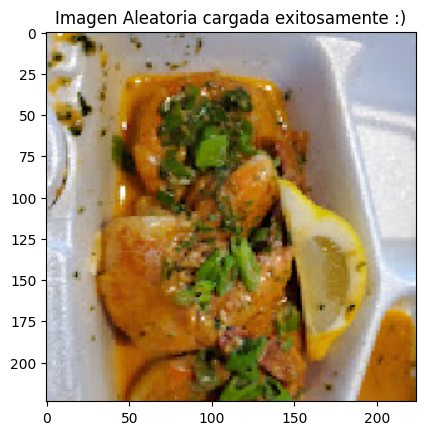

In [280]:
FOLDER = 'reviews'
files = df_sample['img_filename'].tolist()
idx =  random.randint(0, len(files))
original = load_img(f'{FOLDER}/{files[idx]}', target_size=(imgs_model_width, imgs_model_height))
plt.title("Imagen Aleatoria cargada exitosamente :)")
plt.imshow(original)
plt.show()


- `D_IE`: Determina la extraccion de imagenes para poder crear embeddings de cada una usando el modelo vgg19.

In [281]:
D_IE = 0 # Download Images Embeddings

In [282]:
# En una lista iremos guardando cada imagen preprocesada
if D_IE:
    all_images = []
    for f in files_sample:
        prefix = FOLDER
        filename = f'{prefix}/{f}'
        original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
        numpy_image = img_to_array(original)
        image_batch = np.expand_dims(numpy_image, axis=0)

        all_images.append(image_batch)

    images = np.vstack(all_images)

    processed_imgs = preprocess_input(images.copy()) # preprocesamos todas las imagenes
    imgs_features = feat_extractor.predict(processed_imgs)
    print("features extraidos exitosamente! :)")
    print(imgs_features.shape)
    with open('imgs_features_1.npy', 'wb') as file: # guardamos los embeddings
        np.save(file, imgs_features)
else:
    with open('imgs_features.npy', 'rb') as file:
        imgs_features = np.load(file)

In [283]:
# Text modality configurations
VOCAB_SIZE = 5000
item_text_modality = TextModality(
    corpus=df_sample['text'].tolist(),
    id_map=item_to_idx,
    max_vocab=VOCAB_SIZE,
    tokenizer=BaseTokenizer()
)

In [284]:
# Images configurations
item_image_modality = ImageModality(
    features=imgs_features,
    ids=item_to_idx
    )

In [285]:
uir_list = X[['user_id', 'rest_id', 'rating']].values.tolist()

In [286]:
SEED = 42
VERBOSE = True
USE_GPU = torch.cuda.is_available()

In [287]:
X_test.shape[0] / (X.shape[0])

0.09579497387409804

In [299]:
ratio_split = RatioSplit(
    data=uir_list,
    test_size=0.096,
    rating_threshold=3.5,
    item_text=item_text_modality, # agregamos la modalidad de texto
    item_image=item_image_modality, # agregamos la modalidad de imagen
    exclude_unknowns=True,
    seed=SEED,
    verbose=VERBOSE,
)

rating_threshold = 3.5
exclude_unknowns = True
---
Training data:
Number of users = 6600
Number of items = 6181
Number of ratings = 7262
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 6600
Number of items = 6181
Number of ratings = 37
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 6600
Total items = 6181


In [289]:
imgs_features.shape

(8038, 4096)

## Training

In [302]:
# modelo CDL (Collaborative Deep Learning)
''' Por default presenta una cantidad de 50 elementos en el vector de factores latentes.
y SDAE presenta una cantidad de 200 neuronas para la capa intermedia'''
cdl = cornac.models.CDL(
    autoencoder_structure=[200],
    vocab_size=VOCAB_SIZE, # cantidad maxima de vocabulario
    seed=SEED,
    verbose=VERBOSE
)
# modelo VBPR (Visual Bayesian Personalized Ranking)
''' Por default presenta una dimension de 10 elementos para ambos espacios de factores latentes. '''
vbpr = cornac.models.VBPR(
    k=10,   # dimension de gamma en el espacio latente
    k2=10,  # dimension de theta en el espacio latente
    n_epochs=20,
    use_gpu=USE_GPU,
    seed=SEED,
    verbose=VERBOSE
)

In [295]:
def get_metrics(n):
    '''Funcion para obtener las metricas de los modelos de cornac en listas de
    recomendacion de tamaño n.'''
    # numero de n elementos en la lista de recomendacion
    RMSE_n = cornac.metrics.RMSE()
    AUC_n = cornac.metrics.AUC()
    MAP_n = cornac.metrics.MAP()
    MRR_n = cornac.metrics.MRR()

    Recall_n = cornac.metrics.Recall(k=n)
    Precision_n = cornac.metrics.Precision(k=n)
    F1_n = cornac.metrics.FMeasure(k=n)
    nDCG_n = cornac.metrics.NDCG(k=n)
    return [RMSE_n, AUC_n, MAP_n, Recall_n, Precision_n, F1_n, nDCG_n, MRR_n]


## Experiment to recommend 10 restaurants

In [303]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[cdl],
                             metrics=get_metrics(n=10))
text_exp.run()


[CDL] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/37 [00:00<?, ?it/s]

Ranking:   0%|          | 0/37 [00:00<?, ?it/s]


TEST:
...
    |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
CDL | 3.2860 | 0.5614 | 0.0284 | 0.0816 | 0.0814 |  0.0974 |       0.0156 |    0.1562 |  548.7746 |   0.1976



In [316]:
cdl_reclist10 = {}
for user_id in X_test['user_id'].unique():
    # Bajamos la cantidad de usuarios a testear debido a la particion de train y test
    # que implementa Cornac.
    try:
        recs = cdl.recommend(user_id)
        cdl_reclist10[user_id] = recs[:10]
    except ValueError as e:
        continue


In [305]:
print('Cantidad de usuarios en test:', len(cdl_reclist10.keys()))

Cantidad de usuarios en test: 553


In [306]:
cdl_novelty10 = novelty(cdl_reclist10)
cdl_diversity10 = diversity(cdl_reclist10)
print(f'Novelty@{10}: {cdl_novelty10}')
print(f'Diversity@{10}: {cdl_diversity10}')

Novelty@10: 7.524590685377097
Diversity@10: 0.9466546112115696


In [307]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[vbpr],
                             metrics=get_metrics(n=10))
text_exp.run()


[VBPR] Training started!


Epoch 1/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/73 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/37 [00:00<?, ?it/s]

Ranking:   0%|          | 0/37 [00:00<?, ?it/s]


TEST:
...
     |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
---- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
VBPR | 2.0886 | 0.5944 | 0.0000 | 0.0065 | 0.0055 |  0.0000 |       0.0000 |    0.0000 |   23.2860 |   0.3396



In [308]:
def get_reclist(id_user, model, n):
    """ funcion que retorna la lista de recomendaciones para un usuario.
    Valido solo para modelos de cornac. """
    scores_for_user = model.score(id_user)
    scores_for_user = [
        (idx_to_item[idx], score) for idx, score in enumerate(scores_for_user)
    ]
    scores_for_user.sort(key=lambda x: x[1], reverse=True)
    return [i[0] for i in scores_for_user[:n]]

In [309]:
vbpr_reclist10 = {}

for user_id in X_test['user_id'].unique():
    # Bajamos la cantidad de usuarios a testear debido a la particion de train y test
    # que implementa Cornac.
    try:
        recs = vbpr.recommend(user_id)
        vbpr_reclist10[user_id] = recs[:10]
    except ValueError as e:
        continue


In [311]:
len(vbpr_reclist10.keys())

553

In [314]:
vbpr_novelty10 = novelty(vbpr_reclist10)
vbpr_diversity10 = diversity(vbpr_reclist10)
print(f'Novelty@{10}: {vbpr_novelty10}')
print(f'Diversity@{10}: {vbpr_diversity10}')

Novelty@10: 7.453846670386372
Diversity@10: 0.8231464737793851


### Examples

#### User 1

In [358]:
# Recomendaciones de CDL
show_recommendations(user1, cdl_reclist10[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Healthy options, Comfort food

10 RECOMENDACIONES


,name,description,categories
0,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
1,Cold Stone Creamery,Ice cream chain offering design-your-own creat...,Frozen yogurt shop;Ice cream shop;Dessert rest...
2,Chick-fil-A,"Fast-food chain serving chicken sandwiches, st...",Caterer;Breakfast restaurant;Delivery service;...
3,Bangkok Chef,Casual BYOB Thai restaurant serving hearty por...,Hawaiian restaurant;Thai restaurant;Restaurant
4,Arby's,"Fast-food chain, known for its roast beef, ser...",Takeout Restaurant;Sandwich shop;Takeout resta...
5,Fadi's,NaN,Mediterranean restaurant
6,Waffle House,Simple chain spot offering American diner fare...,Diner;Breakfast restaurant;Takeout Restaurant;...
7,Sheetz,Chain offering fuel & familiar convenience goo...,Fast food restaurant;Coffee shop;Gas station;A...
8,DOMOISHI ramen-poke-tea-wings,NaN,Restaurant;Asian fusion restaurant
9,Golden China Restaurant,Unpretentious eatery serving straightforward C...,Diner;Takeout Restaurant;Chinese restaurant;Lu...


In [359]:
show_recommendations(user1, vbpr_reclist10[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Healthy options, Comfort food

10 RECOMENDACIONES


,name,description,categories
0,Bazille,NaN,American restaurant;Restaurant
1,Sweet E's Café,French toast & other breakfast/brunch dishes i...,Breakfast restaurant;Brunch restaurant
2,Dragon Tea,NaN,Bubble tea store;Taiwanese restaurant
3,Fuddruckers,Family-friendly chain for burgers on housemade...,Caterer;Fast food restaurant;American restaura...
4,Prante's,NaN,Restaurant
5,Santa Lucia Restaurante & Pizzeria,Casual Mediterranean restaurant presents pizze...,Caterer;Fine dining restaurant;Takeout Restaur...
6,Ain't Cha Mama's,NaN,Caterer;Contemporary Louisiana restaurant;Sout...
7,Grind Burger Bar y Taquería,NaN,Restaurant
8,Penelope's Cafe-Gallery,NaN,Restaurant
9,Casa del Barco - Chesterfield Towne Center,NaN,Bar;Mexican restaurant


#### User 2

In [360]:
# Recomendaciones de CDL
show_recommendations(user2, cdl_reclist10[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy-hour food, Vegetarian options, Comfort food, Wine, Late-night food
   Kids' menu, Quick bite, Beer, Cocktails, Small plates
   Spirits, Healthy options, Alcohol, Coffee, Happy-hour drinks

10 RECOMENDACIONES


,name,description,categories
0,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
1,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
2,Burger King,Well-known fast-food chain serving grilled bur...,Restaurant;Fast food restaurant
3,Sonic Drive-In,Fast-food burger & fries joint with an old-sch...,Fast food restaurant;Hamburger restaurant;Chic...
4,Hops Kitchen - Pro Re Nata,NaN,Restaurant
5,Kanak Indian Kitchen,NaN,Indian takeaway;Delivery Restaurant;Restaurant...
6,Bojangles,Southern-inspired fast-food chain known for Ca...,Breakfast restaurant;Takeout Restaurant;Sandwi...
7,Peterson's Ice Cream Depot LLC,Window-serve spot for soft-serve & scooped ice...,Dessert shop;Barbecue restaurant;Hot dog resta...
8,Augusta Kitchen,NaN,Restaurant
9,Bizou,Favorites like meatloaf & pot pie join updated...,French restaurant;Bar;American restaurant;Rest...


In [361]:
show_recommendations(user2, vbpr_reclist10[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy-hour food, Vegetarian options, Comfort food, Wine, Late-night food
   Kids' menu, Quick bite, Beer, Cocktails, Small plates
   Spirits, Healthy options, Alcohol, Coffee, Happy-hour drinks

10 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Menchie's Frozen Yogurt,Cheerful self-serve chain with dozens of froze...,Caterer;Dessert shop;Bakery;Frozen yogurt shop...
2,Mona's Kitchen Lebanese Food,Extensive menu of Middle Eastern classics like...,Lebanese restaurant
3,Kaimuki's Boston Pizza,"Homey, checkered-tablecloth spot for Boston-st...",Italian restaurant;Pizza restaurant
4,Wagaya,Compact restaurant featuring an array of ramen...,Ramen restaurant
5,Taste - by Kissing Tree Vineyards,NaN,Wine bar;Coffee shop;Steak house;Winery;Wine s...
6,Dickeys Barbecue,"BBQ chain eatery featuring house-smoked meats,...",Barbecue restaurant;Restaurant
7,Maggie's Taqueria,NaN,Mexican restaurant;Latin American restaurant
8,La Casa Mexicana,NaN,Mexican restaurant;Latin American restaurant
9,Scoops Ice Cream,NaN,Restaurant


#### User 3

In [362]:
# Recomendaciones de CDL
show_recommendations(user3, cdl_reclist10[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Vegetarian options, Comfort food, Wine, Hard liquor
   Happy hour food, Kids' menu, Quick bite, Beer, Cocktails
   Small plates, Healthy options, Alcohol, Coffee

10 RECOMENDACIONES


,name,description,categories
0,Noodles and Company,Counter-serve chain offering international noo...,Takeout Restaurant;Takeout restaurant;Down hom...
1,QuikTrip,"Convenience store chain supplying snacks, sand...",Breakfast restaurant;Gas station;Beer store;Sn...
2,Jing Sushi,Chill location for large portions of standard ...,Asian restaurant;Japanese restaurant;Sushi res...
3,The Zone,Lofty game-day hangout serving pub grub & cock...,Caterer;Children's party service;Bowling alley...
4,Delia’s,NaN,Greek restaurant;Mediterranean restaurant;Ital...
5,Iraqi House Bakery & Restaurant,NaN,Middle Eastern restaurant
6,China One Chinese Restaurant,Utilitarian Chinese takeout joint with some ea...,Delivery Chinese restaurant;Restaurant;Chinese...
7,Cafe Sazon,"Basic, relaxed outpost offering South & Centra...",Coffee shop;Bakery;Latin American restaurant;T...
8,TAZA Shawarma and Falafel,NaN,Middle Eastern restaurant;Lebanese restaurant;...
9,Mr.Sushi & Mrs.Roll,NaN,Restaurant;Japanese restaurant


In [363]:
show_recommendations(user3, vbpr_reclist10[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Vegetarian options, Comfort food, Wine, Hard liquor
   Happy hour food, Kids' menu, Quick bite, Beer, Cocktails
   Small plates, Healthy options, Alcohol, Coffee

10 RECOMENDACIONES


,name,description,categories
0,M & S Kitchen,NaN,Chinese restaurant
1,Wetzel's Pretzels,Handcrafted pretzels come sweet or salty at th...,Pretzel store;Fast food restaurant
2,Wokshop by Xi'an,NaN,Fusion restaurant;Dim sum restaurant;Asian res...
3,Uncle Em's Southern Smokehouse,NaN,Barbecue restaurant
4,Tina's Cafe,NaN,Restaurant
5,Gangnam style korean BBQ restaurant,NaN,Korean restaurant
6,Chopathi India Kitchen,NaN,Indian restaurant
7,Kippy's Kustard,NaN,Ice cream shop;American restaurant
8,China One Chinese Restaurant,Utilitarian Chinese takeout joint with some ea...,Delivery Chinese restaurant;Restaurant;Chinese...
9,Mr.Sushi & Mrs.Roll,NaN,Restaurant;Japanese restaurant


In [326]:
show_recommendations(user2, vbpr_reclist10[user2])

PERFIL DEL USUARIO
- Palabras claves:
   burger, chicken, chips, cream, definitely
   didnt, dining, dogs, enjoyed, friendly
   good, great, lunch, naan, onions
   plus, recommendations, salad, stop, visit
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Comfort food, Late-night food, Quick bite, Small plates, Coffee
   Happy-hour drinks, Happy-hour food, Hard liquor, Kids' menu, Beer
   Cocktails, Healthy options, Halal food, Spirits, All you can eat
   Vegetarian options, Alcohol, Wine, Salad bar

10 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Menchie's Frozen Yogurt,Cheerful self-serve chain with dozens of froze...,Caterer;Dessert shop;Bakery;Frozen yogurt shop...
2,Mona's Kitchen Lebanese Food,Extensive menu of Middle Eastern classics like...,Lebanese restaurant
3,Kaimuki's Boston Pizza,"Homey, checkered-tablecloth spot for Boston-st...",Italian restaurant;Pizza restaurant
4,Wagaya,Compact restaurant featuring an array of ramen...,Ramen restaurant
5,Taste - by Kissing Tree Vineyards,NaN,Wine bar;Coffee shop;Steak house;Winery;Wine s...
6,Dickeys Barbecue,"BBQ chain eatery featuring house-smoked meats,...",Barbecue restaurant;Restaurant
7,Maggie's Taqueria,NaN,Mexican restaurant;Latin American restaurant
8,La Casa Mexicana,NaN,Mexican restaurant;Latin American restaurant
9,Scoops Ice Cream,NaN,Restaurant


## Experiment to recommend 20 restaurants

In [332]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[cdl, vbpr],
                             metrics=get_metrics(n=20))
text_exp.run()


[CDL] Training started!


/usr/local/lib/python3.10/dist-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/37 [00:00<?, ?it/s]

Ranking:   0%|          | 0/37 [00:00<?, ?it/s]


[VBPR] Training started!


Epoch 1/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/73 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/37 [00:00<?, ?it/s]

Ranking:   0%|          | 0/37 [00:00<?, ?it/s]


TEST:
...
     |   RMSE |    AUC |  F1@20 |    MAP |    MRR | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
---- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
CDL  | 3.2924 | 0.6007 | 0.0179 | 0.0753 | 0.0753 |  0.1004 |       0.0094 |    0.1875 |  543.2000 |   0.1924
VBPR | 1.8699 | 0.5445 | 0.0089 | 0.0211 | 0.0211 |  0.0373 |       0.0047 |    0.0938 |   22.9195 |   0.2103



In [333]:
cdl_reclist20 = {}
for user_id in X_test['user_id'].unique():
    # Bajamos la cantidad de usuarios a testear debido a la particion de train y test
    # que implementa Cornac.
    try:
        recs = cdl.recommend(user_id)
        cdl_reclist20[user_id] = recs[:20]
    except ValueError as e:
        continue

In [334]:
cdl_novelty20 = novelty(cdl_reclist20)
cdl_diversity20 = diversity(cdl_reclist20)
print(f'Novelty@{20}: {cdl_novelty10}')
print(f'Diversity@{20}: {cdl_diversity20}')

Novelty@20: 7.524590685377097
Diversity@20: 0.928028933092221


In [336]:
vbpr_reclist20 = {}
for user_id in X_test['user_id'].unique():
    # Bajamos la cantidad de usuarios a testear debido a la particion de train y test
    # que implementa Cornac.
    try:
        recs = vbpr.recommend(user_id)
        vbpr_reclist20[user_id] = recs[:20]
    except ValueError as e:
        continue

In [337]:
vbpr_novelty20 = novelty(vbpr_reclist20)
vbpr_diversity20 = diversity(vbpr_reclist20)
print(f'Novelty@{20}: {vbpr_novelty20}')
print(f'Diversity@{20}: {vbpr_diversity20}')

Novelty@20: 7.035813854532068
Diversity@20: 0.7960216998191686


### Examples

#### User 1

In [366]:
show_recommendations(user1, cdl_reclist20[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Healthy options, Comfort food

20 RECOMENDACIONES


,name,description,categories
0,Papa John's Pizza,Take-out/delivery chain offering classic & spe...,Delivery Restaurant;Pizza restaurant
1,Chick-fil-A,"Fast-food chain serving chicken sandwiches, st...",Caterer;Breakfast restaurant;Delivery service;...
2,La Costenita Mexican Food,NaN,Mexican restaurant;Restaurant
3,Tastea Grill,NaN,Japanese restaurant;Sushi restaurant;Asian res...
4,El Indio Tortillas Factory,NaN,Mexican restaurant
5,Clean Juice,NaN,Breakfast restaurant;Fruits wholesaler;Vegetar...
6,Brick Oven Pizza,Casual restaurant with a full bar serving hear...,Pizza restaurant
7,I Lava Tacos,NaN,Mexican restaurant
8,King's Chinese Barbecue,NaN,Barbecue restaurant
9,Cafe il Mondo,"Stone-baked pizzas, calzones & espresso star a...",Italian restaurant


In [367]:
show_recommendations(user1, vbpr_reclist20[user1])

PERFIL DEL USUARIO
- Palabras claves:
   bigger, food, got, great, im
   juices, later, lot, main, near
   number, pay, pomegranate, sides, sitting
   squeezed, stomach, togo, tonight, way
- Sentimiendo dominante:  positive
- Lugares visitados:  Texas
- Caracteristicas de restaurantes visitados:
   Healthy options, Comfort food

20 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Diamond Steakhouse,NaN,Steak house;Seafood restaurant;Lounge
2,NeighborHOOD Cafe,NaN,Delivery Restaurant;Sandwich shop
3,Pickled porch cafe,NaN,Restaurant
4,Bazille,NaN,American restaurant;Restaurant
5,Wendy's,Fast-food burger chain serving sides such as c...,Breakfast restaurant;Hamburger restaurant;Rest...
6,Fatso's Bunker,NaN,Hamburger restaurant
7,Toni's Pizza,NaN,Restaurant
8,CC Cookies & Cream,NaN,Breakfast restaurant;Sandwich shop;Lunch resta...
9,nyloS Restaurant,"Intimate, warmly-lit eatery offering a seasona...",Fine dining restaurant;Restaurant


#### User 2

In [368]:
show_recommendations(user2, cdl_reclist20[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy-hour food, Vegetarian options, Comfort food, Wine, Late-night food
   Kids' menu, Quick bite, Beer, Cocktails, Small plates
   Spirits, Healthy options, Alcohol, Coffee, Happy-hour drinks

20 RECOMENDACIONES


,name,description,categories
0,Domino's Pizza,Delivery/carryout chain offering a wide range ...,Takeout Restaurant;Pizza delivery;Pizza Takeou...
1,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
2,Pizza Hut Express,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Lunch restaurant;Pizza deli...
3,Little Caesars Pizza,"Carry-out chain featuring chicken wings, signa...",Pizza delivery;Pizza Takeout;Chicken wings res...
4,Burger King,Well-known fast-food chain serving grilled bur...,Restaurant;Fast food restaurant
5,Ichiriki Japanese Nabe Restaurant,"An array of classic hot pots, from curry to ki...",Hot pot restaurant;Restaurant
6,Ma'Ona Musubi,Low-key stop for local-Japanese inspired onigi...,Restaurant;Japanese restaurant
7,Moon Garden Restaurant,NaN,Asian restaurant;Chinese restaurant;Restaurant
8,Cafe il Mondo,"Stone-baked pizzas, calzones & espresso star a...",Italian restaurant
9,Sonic Drive-In,Fast-food burger & fries joint with an old-sch...,Fast food restaurant;Hamburger restaurant;Chic...


In [369]:
show_recommendations(user2, vbpr_reclist20[user2])

PERFIL DEL USUARIO
- Palabras claves:
   81, friendly, patio, plus, recommendations
   regular, rice, roasted, rotisserie, salad
   smores, spinach, spot, staff, stop
   tomato, trailer, travel, traveling, weekend
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy-hour food, Vegetarian options, Comfort food, Wine, Late-night food
   Kids' menu, Quick bite, Beer, Cocktails, Small plates
   Spirits, Healthy options, Alcohol, Coffee, Happy-hour drinks

20 RECOMENDACIONES


,name,description,categories
0,Subway,Casual counter-serve chain for build-your-own ...,Caterer;Fast food restaurant;Takeout Restauran...
1,Menchie's Frozen Yogurt,Cheerful self-serve chain with dozens of froze...,Caterer;Dessert shop;Bakery;Frozen yogurt shop...
2,Mona's Kitchen Lebanese Food,Extensive menu of Middle Eastern classics like...,Lebanese restaurant
3,Skippy's Egg Store,NaN,Egg supplier;Spice store;Restaurant supply sto...
4,Wetzel's Pretzels,Handcrafted pretzels come sweet or salty at th...,Pretzel store;Fast food restaurant
5,Mariscos Valencia Restaurant,NaN,Mexican restaurant
6,Asian Seafood,NaN,Asian restaurant;Seafood restaurant
7,Ohana Bar-B-Q,NaN,Barbecue restaurant;Korean restaurant
8,Kaimuki's Boston Pizza,"Homey, checkered-tablecloth spot for Boston-st...",Italian restaurant;Pizza restaurant
9,Wagaya,Compact restaurant featuring an array of ramen...,Ramen restaurant


#### User 3

In [370]:
show_recommendations(user3, cdl_reclist20[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Vegetarian options, Comfort food, Wine, Hard liquor
   Happy hour food, Kids' menu, Quick bite, Beer, Cocktails
   Small plates, Healthy options, Alcohol, Coffee

20 RECOMENDACIONES


,name,description,categories
0,Burgerim,NaN,Delivery Restaurant;Hamburger restaurant;Resta...
1,Starbucks,Seattle-based coffeehouse chain known for its ...,Breakfast restaurant;Coffee shop;Coffee store;...
2,Pizza Hut,Family-friendly chain known for its made-to-or...,Takeout Restaurant;Delivery Restaurant;Deliver...
3,First Watch,"Cafe chain for health-minded breakfast, brunch...",Diner;Breakfast restaurant;Brunch restaurant;C...
4,Bubba's 33,"Burgers, pizza & beer served alongside many la...",Family restaurant;Sports bar;American restaura...
5,Wawa,Convenience store chain known for sandwiches &...,Breakfast restaurant;Coffee shop;Cheesesteak r...
6,Burger King,Well-known fast-food chain serving grilled bur...,Restaurant;Fast food restaurant
7,Ninja Sushi,"Counter-serve Japanese chain offering sushi, u...",Restaurant;Sushi restaurant
8,Arby's,"Fast-food chain, known for its roast beef, ser...",Takeout Restaurant;Sandwich shop;Takeout resta...
9,QuikTrip,"Convenience store chain supplying snacks, sand...",Breakfast restaurant;Gas station;Beer store;Sn...


In [371]:
show_recommendations(user3, vbpr_reclist20[user3])

PERFIL DEL USUARIO
- Palabras claves:
   awesome, chef, delicious, dishes, empanadas
   especially, fantastic, food, good, latin
   perfect, pizzas, salmon, spot, staff
- Sentimiendo dominante:  positive
- Lugares visitados:  Virginia
- Caracteristicas de restaurantes visitados:
   Happy hour drinks, Vegetarian options, Comfort food, Wine, Hard liquor
   Happy hour food, Kids' menu, Quick bite, Beer, Cocktails
   Small plates, Healthy options, Alcohol, Coffee

20 RECOMENDACIONES


,name,description,categories
0,M & S Kitchen,NaN,Chinese restaurant
1,Coastal Grill,NaN,Fine dining restaurant
2,Sbarro,Italian fast-food chain offering thin-crust pi...,Caterer;Italian restaurant;Pizza delivery;Past...
3,Dunkin',Long-running chain serving signature breakfast...,Breakfast restaurant;Coffee shop;Takeout Resta...
4,Chico's Grill,Mexican dishes with healthy ingredients served...,Caterer;Mexican restaurant
5,McDonald's,"Classic, long-running fast-food chain known fo...",Breakfast restaurant;Coffee shop;Sandwich shop...
6,Mr. East Kitchen,NaN,Breakfast restaurant;Thai restaurant;Asian res...
7,Hive Coffee • Bar,"Stylish, hip-casual venue offering coffee, tea...",Coffee shop;Coffee store;Cafe;Tea store;Bar;Co...
8,Coffee & Bagels,Eco-conscious coffee chain offering java drink...,Cafe;Breakfast restaurant;Coffee shop
9,Wise Eats & Treats,NaN,Barbecue restaurant


## Experiment to recommend 30 restaurants

In [372]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[cdl, vbpr],
                             metrics=get_metrics(n=30))
text_exp.run()


[CDL] Training started!


/usr/local/lib/python3.10/dist-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/37 [00:00<?, ?it/s]

Ranking:   0%|          | 0/37 [00:00<?, ?it/s]


[VBPR] Training started!


Epoch 1/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/73 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/37 [00:00<?, ?it/s]

Ranking:   0%|          | 0/37 [00:00<?, ?it/s]


TEST:
...
     |   RMSE |    AUC |  F1@30 |    MAP |    MRR | NDCG@30 | Precision@30 | Recall@30 | Train (s) | Test (s)
---- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
CDL  | 3.2936 | 0.5767 | 0.0101 | 0.0864 | 0.0861 |  0.1005 |       0.0052 |    0.1562 |  543.9647 |   0.3535
VBPR | 1.6909 | 0.5890 | 0.0060 | 0.0526 | 0.0526 |  0.0625 |       0.0031 |    0.0938 |   23.9401 |   0.2278



# Fuentes:
> [1] Wang, H., Wang, N., & Yeung, D. Y. (2015, August). Collaborative deep learning for recommender systems. In Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1235-1244).

> [2] He, R., & McAuley, J. (2016, February). VBPR: visual bayesian personalized ranking from implicit feedback. In Thirtieth AAAI Conference on Artificial Intelligence.

Links:

> (1) https://github.com/PreferredAI/tutorials/blob/master/multimodal-recsys/02_multimodality.ipynb

> (2) https://github.com/PreferredAI/tutorials/tree/master